In [92]:
import torch
import torchvision
import torchvision.transforms as transforms
import ssl
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import pathlib
import time
import os
import random
import json
ssl._create_default_https_context = ssl._create_unverified_context

## Tests

In [93]:
device = "cuda"

In [94]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
trainloader_acc = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [95]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
#imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [96]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, N_layers, M_per_layer, max_rank=None, activation=F.relu):
        super().__init__()
        if max_rank is None: max_rank = M_per_layer
        
        self.layers_a = []
        for i in range(N_layers):
            in_n = 32**2*3 if i==0 else M_per_layer
            out_n = 10 if i==N_layers-1 else M_per_layer
            self.layers_a.append(nn.Linear(in_n, out_n, bias=False))
            with torch.no_grad():
                Wahh = self.layers_a[i].weight
                Wahh = np.random.randn(Wahh.shape[0], Wahh.shape[1])
                u, s, vT = np.linalg.svd(Wahh, full_matrices=False)  # np.linalg.svd returns v transpose!
                Wahh = u @ vT  # make the eigenvalues large so they decay slowly
                Wahh = torch.tensor(Wahh, dtype=torch.float32)
                self.layers_a[i].weight[:, :] = Wahh[:, :]
        self.layers_a = nn.ModuleList(self.layers_a)
        self.activation = F.relu
        self.N_layers = N_layers

    def forward(self, x):
        x = torch.flatten(x, 1)
        for i in range(self.N_layers):
            x = self.layers_a[i](x)
            if i < self.N_layers-1:
                x = self.activation(x)
        return x
class Net_Rank(nn.Module):
    def __init__(self, N_layers, M_per_layer, max_rank=None, activation=F.relu):
        super().__init__()
        if max_rank is None: max_rank = M_per_layer
        
        self.layers_a = []
        self.layers_b = []
        for i in range(N_layers):
            in_n = 32**2*3 if i==0 else M_per_layer
            out_n = 10 if i==N_layers-1 else M_per_layer
            self.layers_a.append(nn.Linear(in_n, max_rank, bias=False))
            self.layers_b.append(nn.Linear(max_rank, out_n, bias=False))
            with torch.no_grad():
                Wahh = self.layers_a[i].weight
                Wahh = np.random.randn(Wahh.shape[0], Wahh.shape[1])
                u, s, vT = np.linalg.svd(Wahh, full_matrices=False)  # np.linalg.svd returns v transpose!
                Wahh = u @ vT  # make the eigenvalues large so they decay slowly
                Wahh = torch.tensor(Wahh, dtype=torch.float32)
                self.layers_a[i].weight[:, :] = Wahh[:, :]
            with torch.no_grad():
                Wahh = self.layers_b[i].weight
                Wahh = np.random.randn(Wahh.shape[0], Wahh.shape[1])
                u, s, vT = np.linalg.svd(Wahh, full_matrices=False)  # np.linalg.svd returns v transpose!
                Wahh = u @ vT  # make the eigenvalues large so they decay slowly
                Wahh = torch.tensor(Wahh, dtype=torch.float32)
                self.layers_b[i].weight[:, :] = Wahh[:, :]
        self.layers_a = nn.ModuleList(self.layers_a)
        self.layers_b = nn.ModuleList(self.layers_b)
        self.activation = F.relu
        self.N_layers = N_layers

    def forward(self, x):
        x = torch.flatten(x, 1)
        for i in range(self.N_layers):
            x = self.layers_a[i](x)
            x = self.layers_b[i](x)
            if i < self.N_layers-1:
                x = self.activation(x)
        return x
    
def accuracy(net, test=False):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader if test else trainloader_acc:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [97]:
net = Net_Rank(N_layers=6, M_per_layer=1000)

In [98]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.05)
#print(accuracy(net))
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.10f}')
            #print(accuracy(net))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 2.1222021997
[1,    40] loss: 1.9618123710
[1,    60] loss: 1.9918892920
[1,    80] loss: 2.0040222943
[1,   100] loss: 1.9646387398
[1,   120] loss: 1.9421940207
[1,   140] loss: 1.9364950895
[1,   160] loss: 1.9297151923
[1,   180] loss: 1.9325982332
[1,   200] loss: 1.9584552109
[1,   220] loss: 2.0091821015
[1,   240] loss: 1.9192757130
[1,   260] loss: 1.8914610326
[1,   280] loss: 1.8988709748
[1,   300] loss: 1.9011424720
[1,   320] loss: 1.8940403342
[1,   340] loss: 1.8578228593
[1,   360] loss: 1.8673395693
[1,   380] loss: 1.9029702127
[2,    20] loss: 1.9335515440


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe21f899f70>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1322, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/Library/Framewo

KeyboardInterrupt: 

In [185]:
print(accuracy(net)), print(accuracy(net, test=True))

1.0
0.5624


(None, None)

## Figures

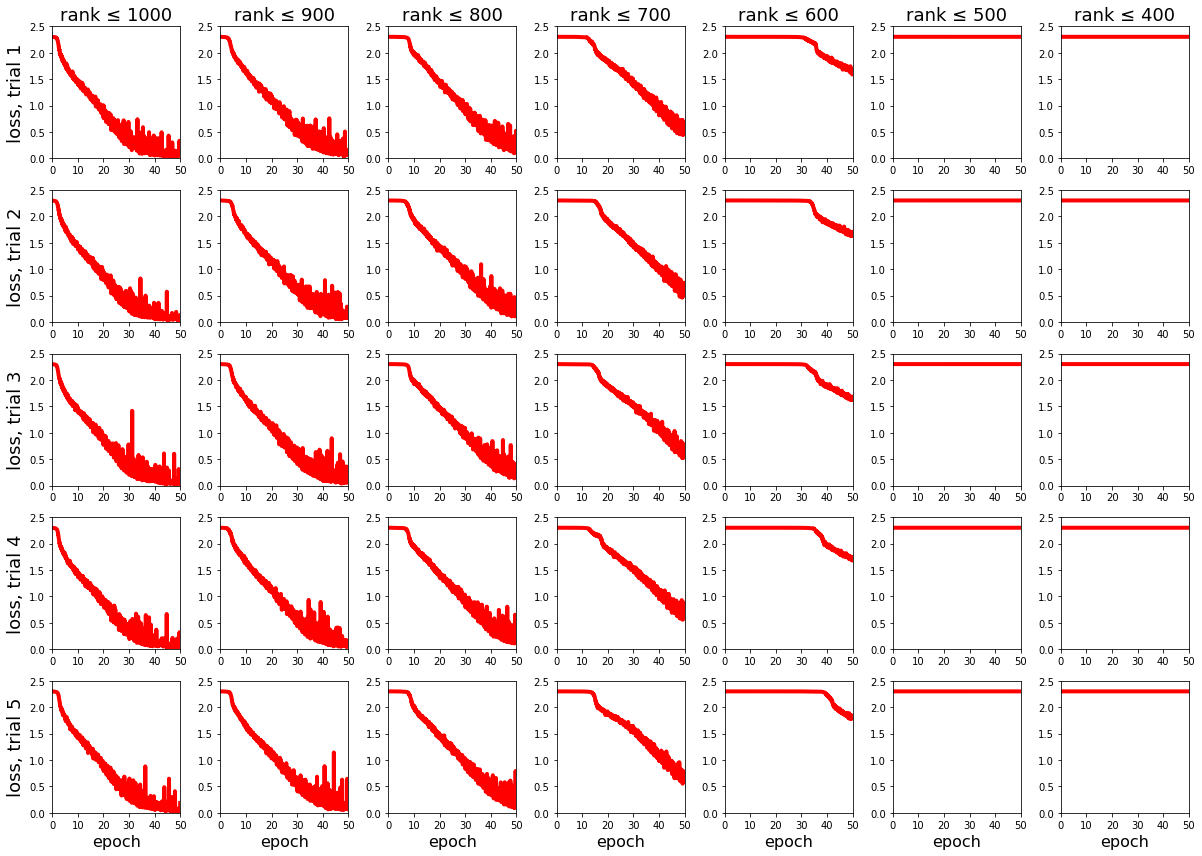

In [69]:
n_layers = 12
m_per_layer = 1000
n_epochs = 50
batch_size = 128
lr = 0.005
init_randoms = range(1, 6)
max_ranks = range(1000, 399, -100)
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        #filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_1_nomomentum/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, 50)
        ax.set_xticks([0, 10, 20, 30, 40, 50])
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"loss, trial {i+1}", fontsize=18)
        if i==len(init_randoms)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

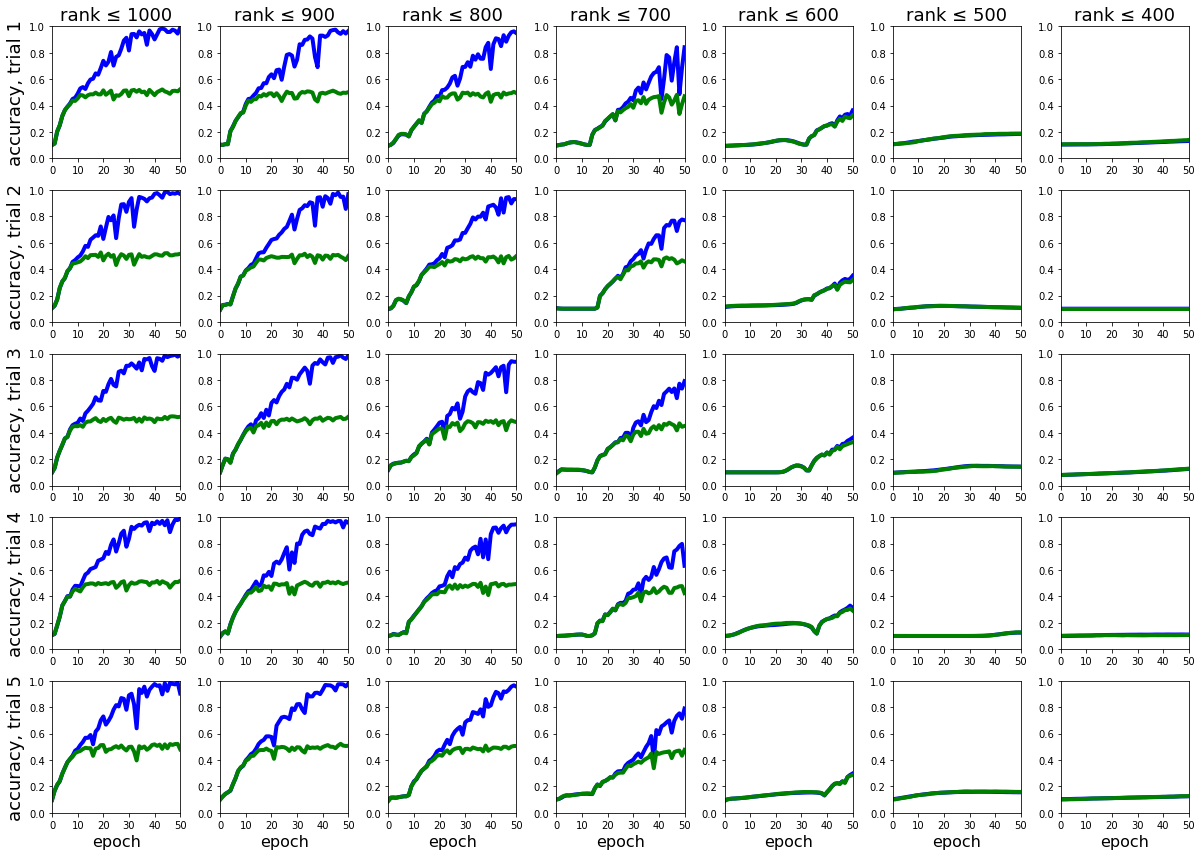

In [73]:
init_randoms = range(1, 6)
max_ranks = range(1000, 399, -100)
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        #filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_1_nomomentum/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        #ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.plot(data["train_acc"], color="b", linewidth=4)
        ax.plot(data["test_acc"], color="g", linewidth=4)
        ax.set_xticks([0, 10, 20, 30, 40, 50])
        ax.set_ylim(0, 1)
        ax.set_xlim(0, 50)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"accuracy, trial {i+1}", fontsize=18)
        if i==len(init_randoms)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

### lr or momentum try

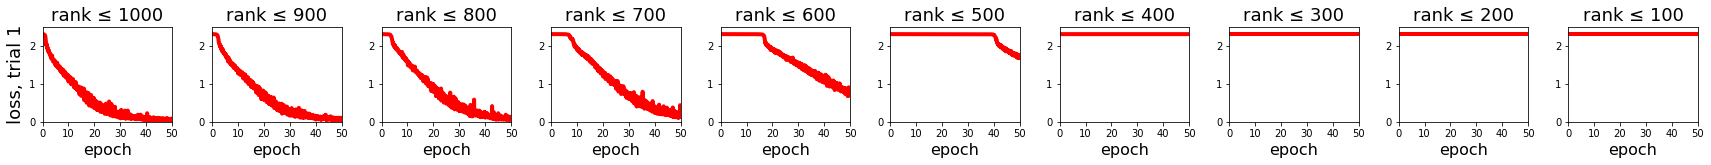

In [75]:
n_layers = 12
m_per_layer = 1000
n_epochs = 50
batch_size = 128
lr = 0.005
init_randoms = range(0, 1)
max_ranks = range(1000, 99, -100)
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{0.01}"
        with open(f"results_1_lr_or_momentum/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, 50)
        ax.set_xticks([0, 10, 20, 30, 40, 50])
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"loss, trial {i+1}", fontsize=18)
        if i==len(init_randoms)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

### A lot of lr

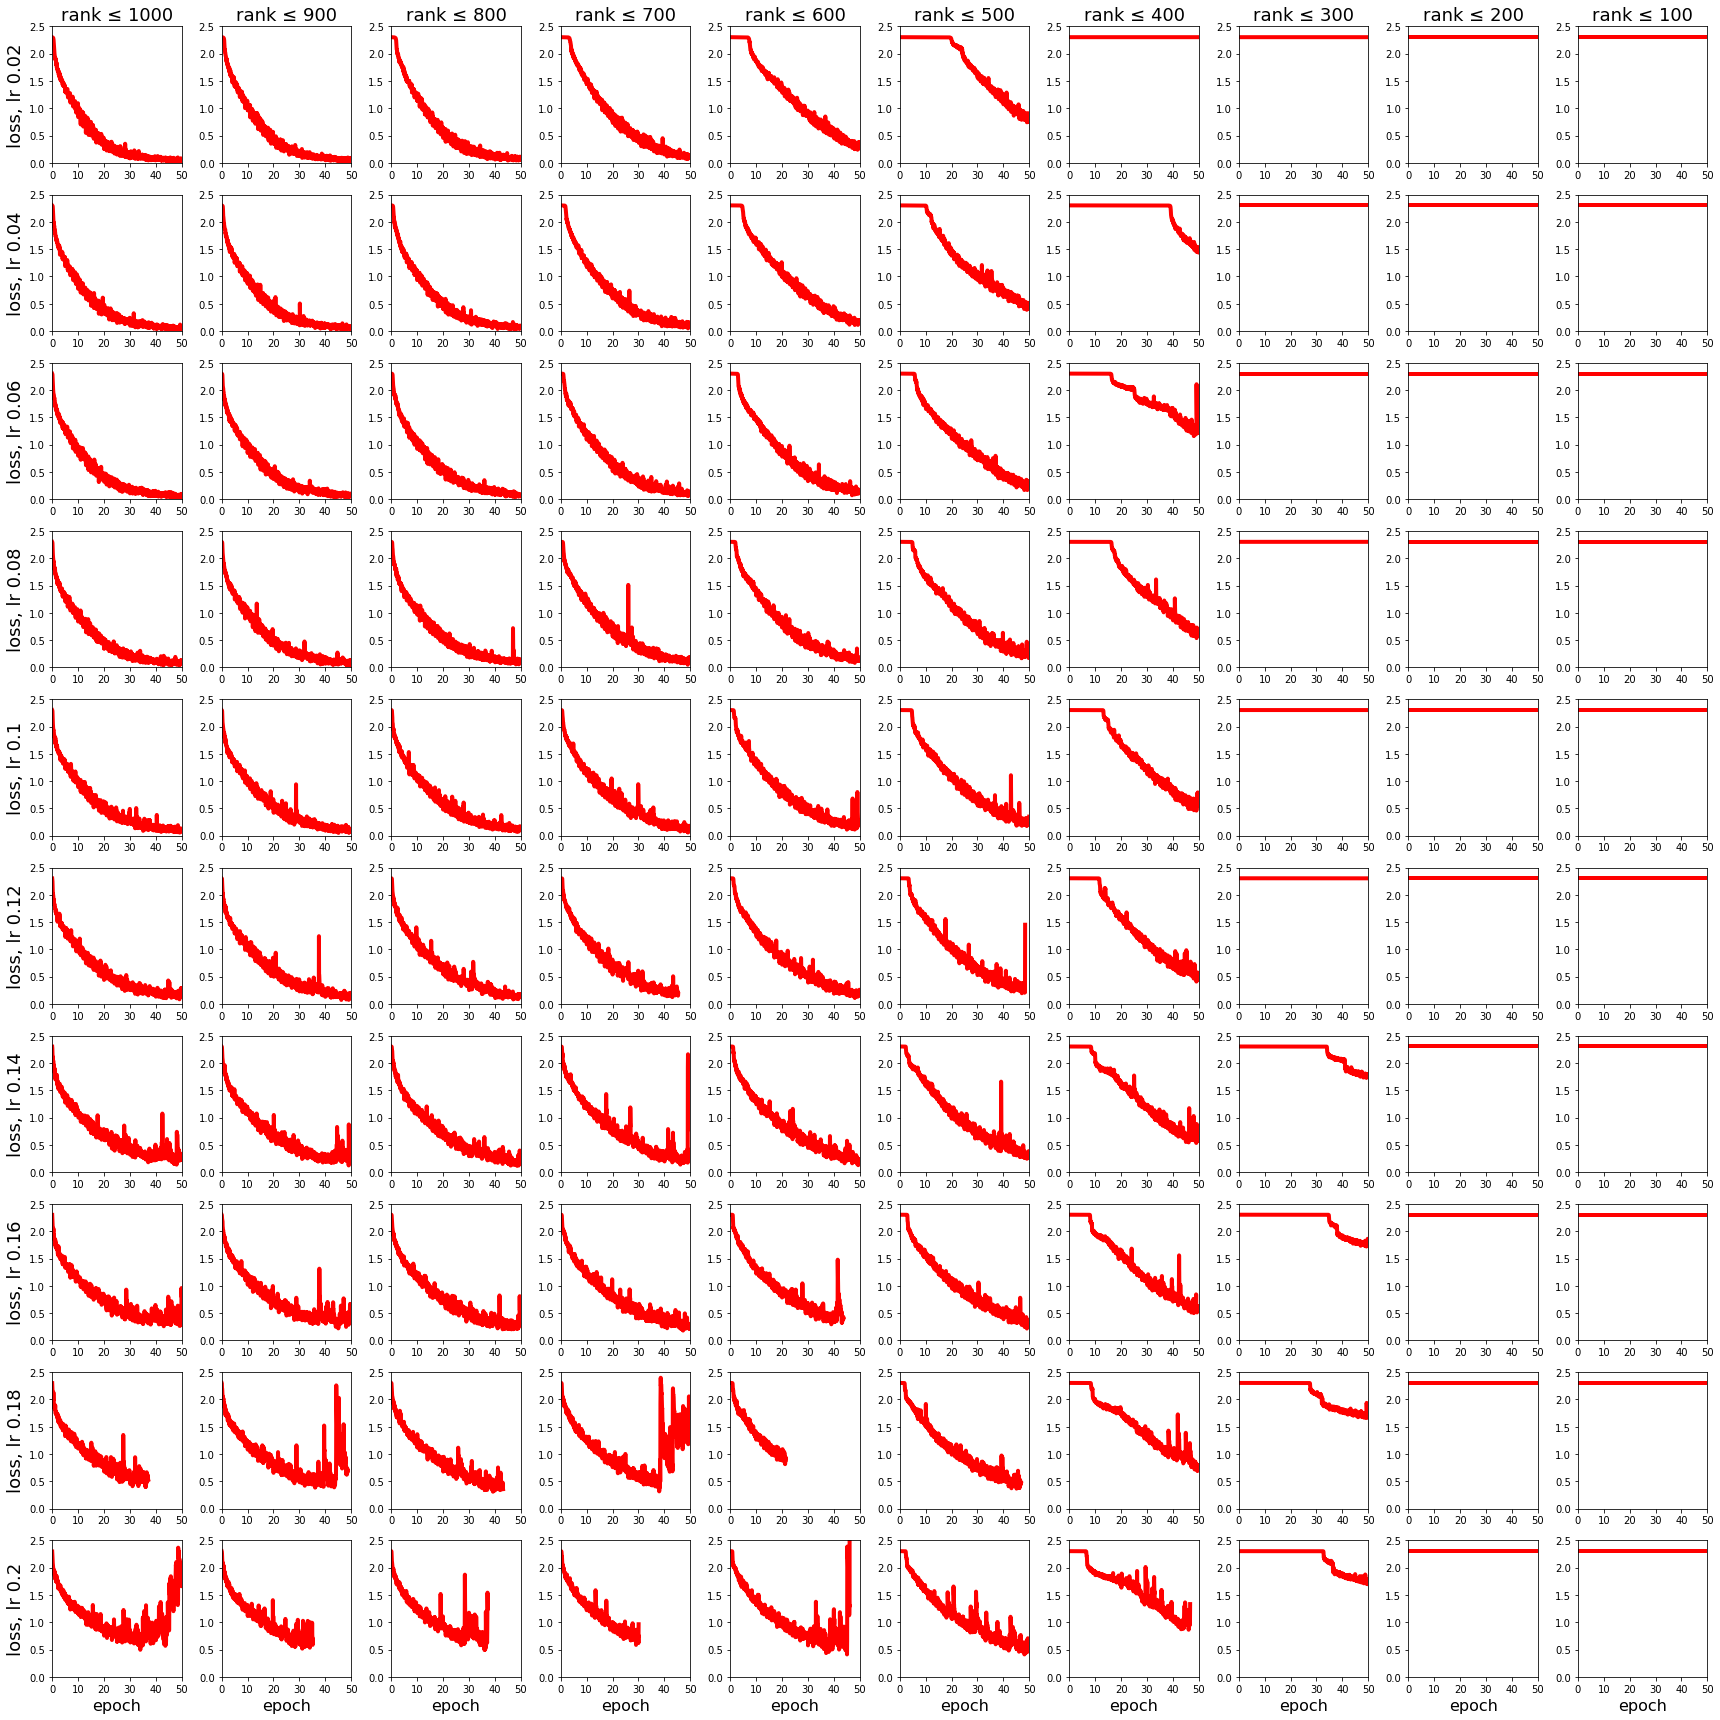

In [88]:
n_layers = 12
m_per_layer = 1000
n_epochs = 50
batch_size = 128
lr = 0.005
init_randoms = range(0, 1)
learning_rates = np.arange(0.02, 0.21, 0.02)
max_ranks = range(1000, 99, -100)
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(learning_rates)))
for j, max_rank in enumerate(max_ranks):
    for i, lr in enumerate(learning_rates):
        lr = round(lr*1000)/1000
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_lr/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(learning_rates), len(max_ranks), i * len(max_ranks) + j+1)
        ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, 50)
        ax.set_xticks([0, 10, 20, 30, 40, 50])
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"loss, lr {lr}", fontsize=18)
        if i==len(learning_rates)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

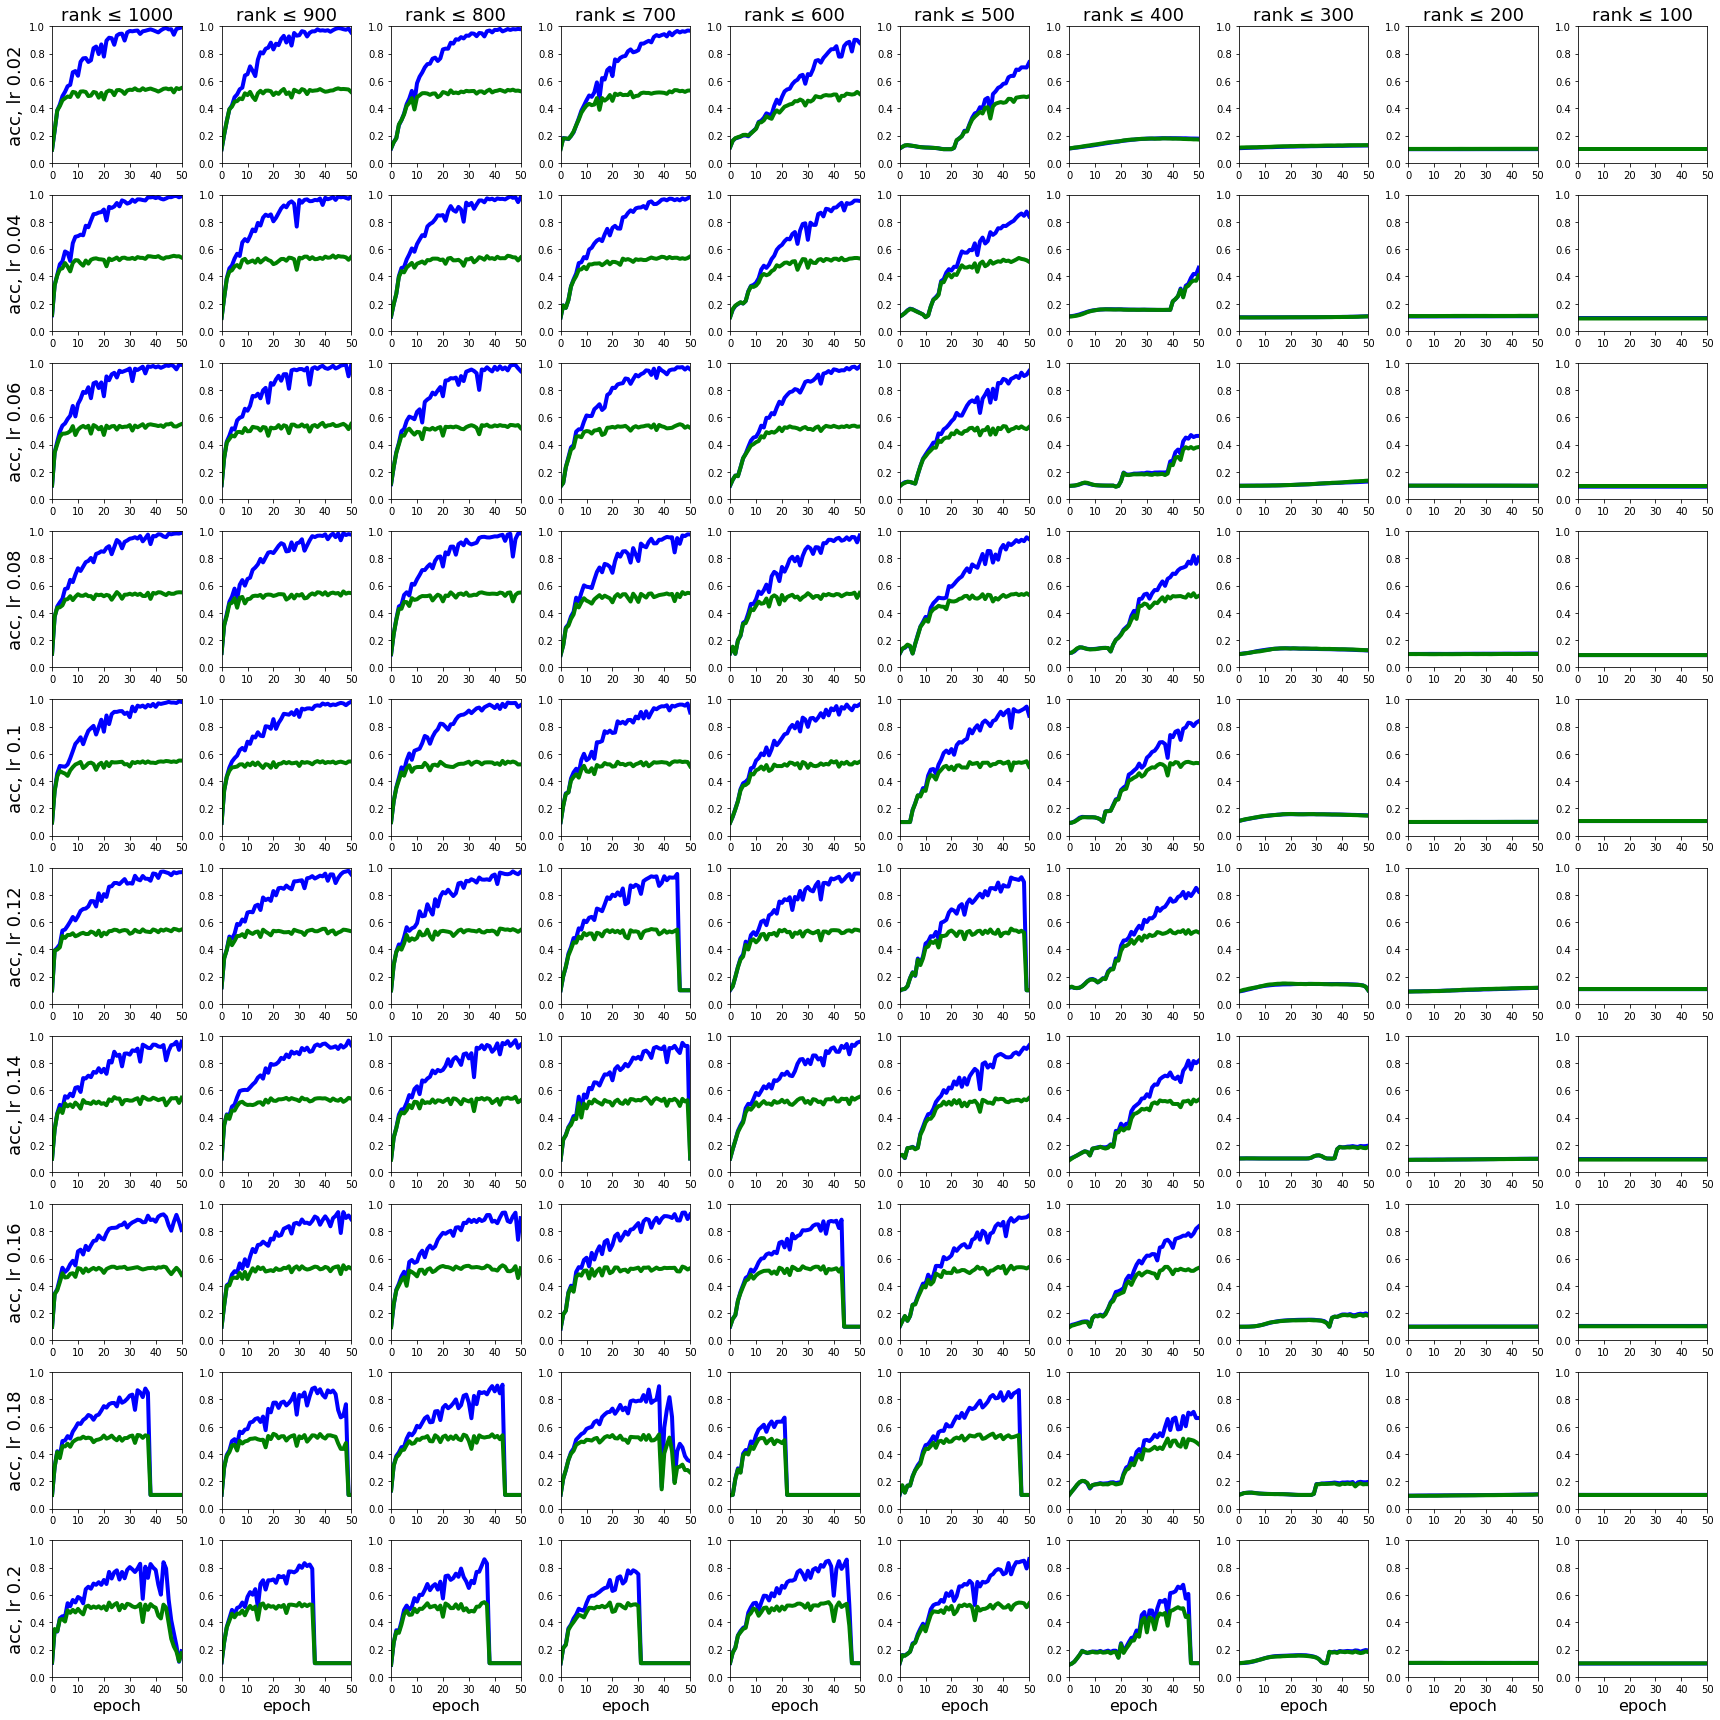

In [90]:
n_layers = 12
m_per_layer = 1000
n_epochs = 50
batch_size = 128
lr = 0.005
init_randoms = range(0, 1)
learning_rates = np.arange(0.02, 0.21, 0.02)
max_ranks = range(1000, 99, -100)
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(learning_rates)))
for j, max_rank in enumerate(max_ranks):
    for i, lr in enumerate(learning_rates):
        lr = round(lr*1000)/1000
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_lr/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(learning_rates), len(max_ranks), i * len(max_ranks) + j+1)
        #ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        #ax.set_ylim(0, 2.5)
        ax.set_xlim(0, 50)
        ax.set_xticks([0, 10, 20, 30, 40, 50])
        ax.plot(data["train_acc"], color="b", linewidth=4)
        ax.plot(data["test_acc"], color="g", linewidth=4)
        ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"acc, lr {lr}", fontsize=18)
        if i==len(learning_rates)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

## 6 layers, 0.1 lr

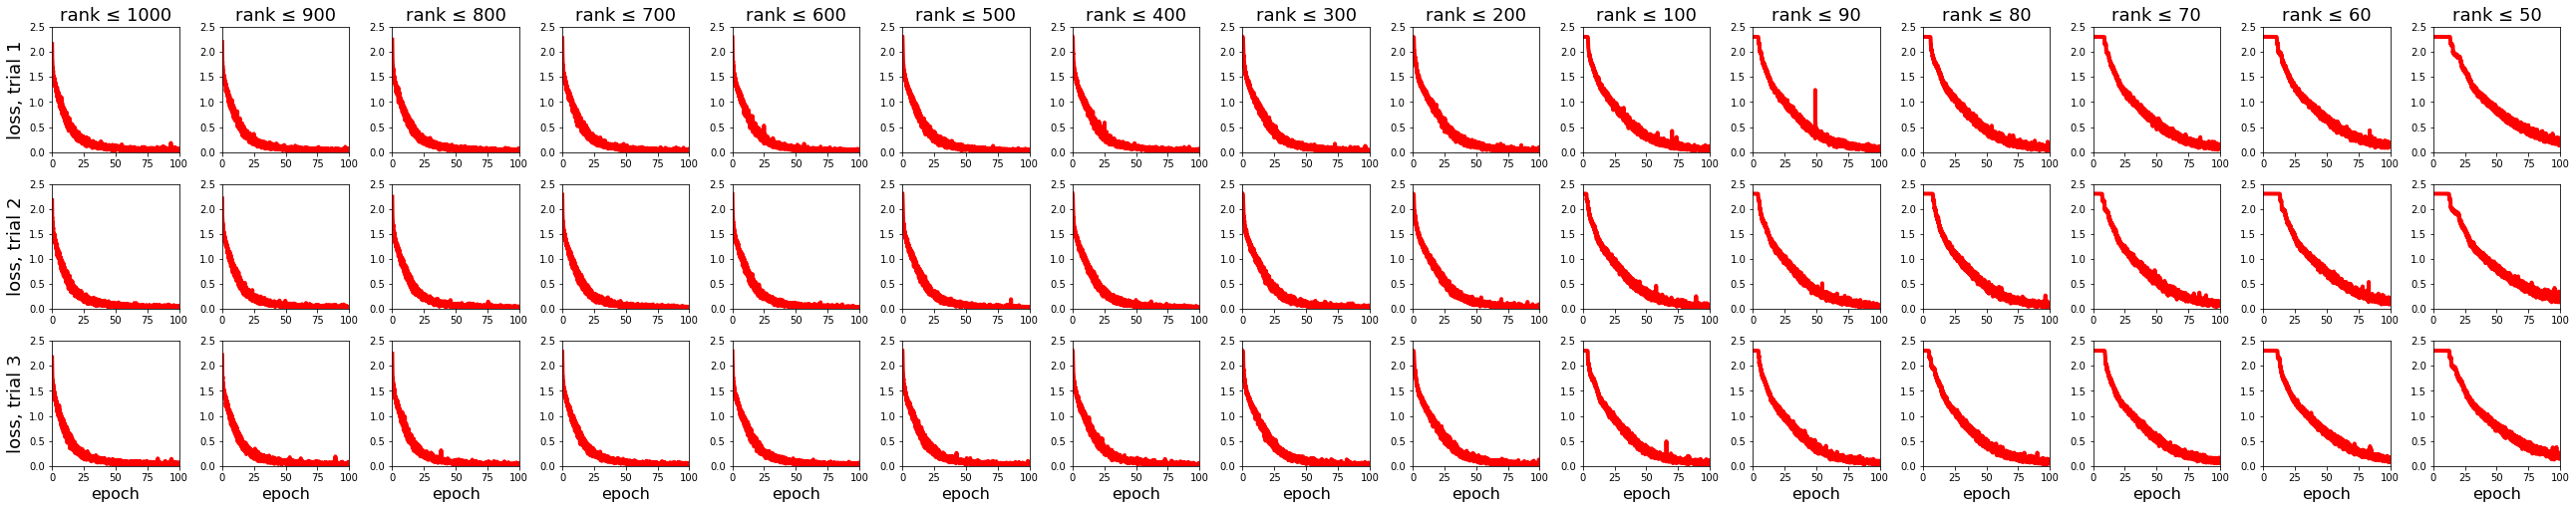

In [110]:
n_layers = 6
m_per_layer = 1000
n_epochs = 100
batch_size = 128
lr = 0.1
init_randoms = range(0, 3)
max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_6l/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, 100)
        ax.set_xticks(np.linspace(0, 100, 5))
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"loss, trial {i+1}", fontsize=18)
        if i==len(init_randoms)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

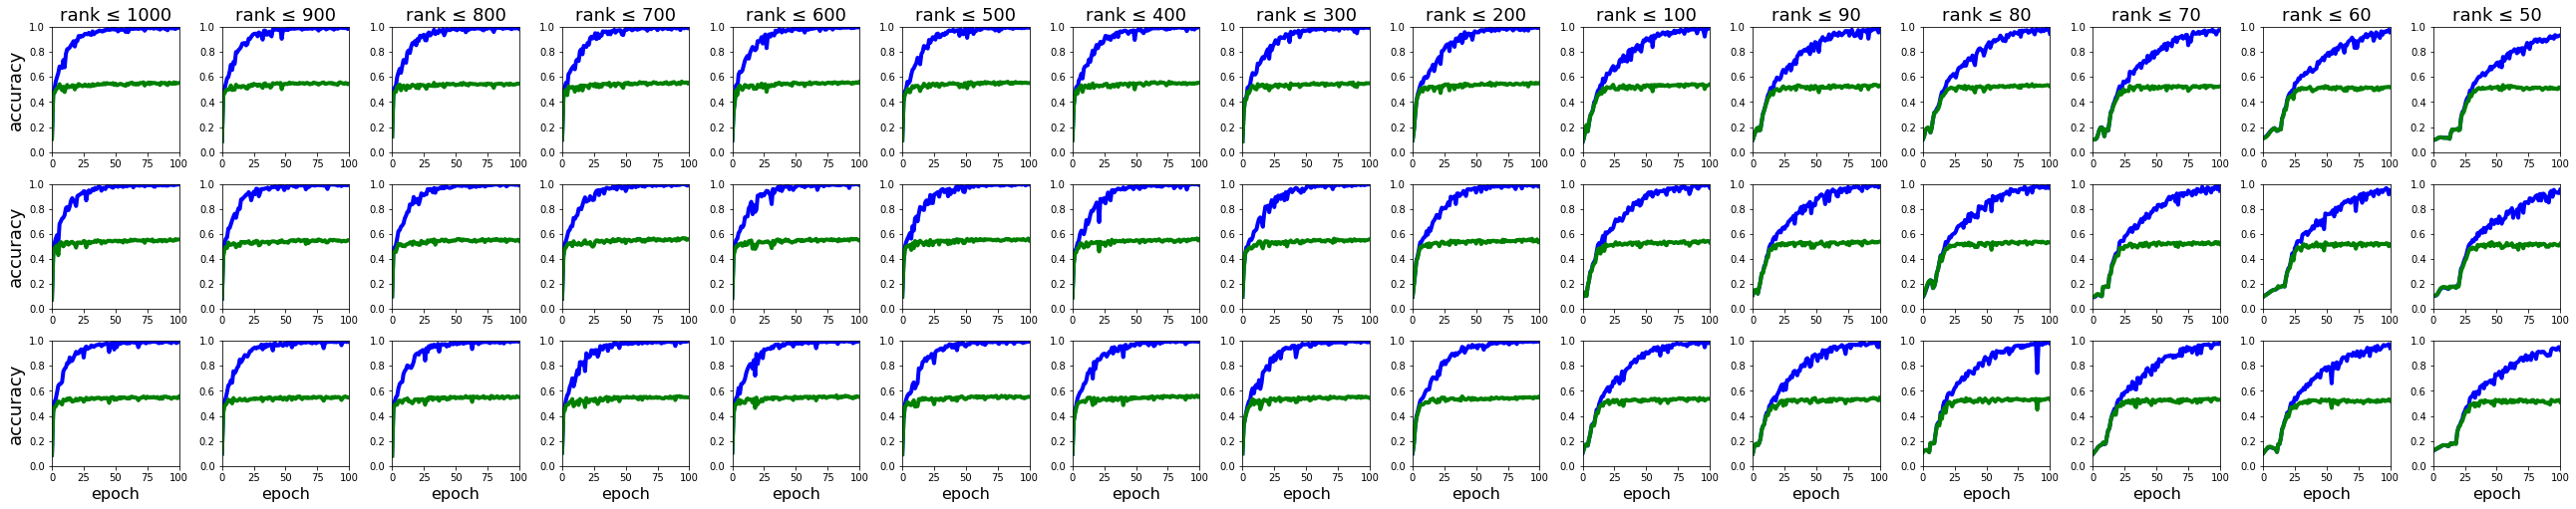

In [169]:
n_layers = 6
m_per_layer = 1000
n_epochs = 100
batch_size = 128
lr = 0.1
init_randoms = range(0, 3)
#max_ranks = range(1000, 99, -100)
max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_6l/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        #ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, 100)
        ax.set_xticks(np.linspace(0, 100, 5))
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        ax.plot(data["train_acc"], color="b", linewidth=4)
        ax.plot(data["test_acc"], color="g", linewidth=4)
        ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"accuracy", fontsize=18)
        if i==len(init_randoms)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

## Compare max rank and just net

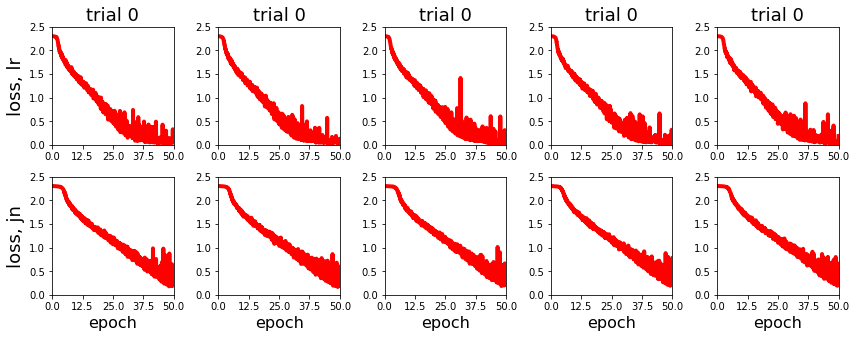

In [114]:
n_layers = 12
m_per_layer = 1000
n_epochs = 50
batch_size = 128
lr = 0.005
init_randoms = range(0, 2)
max_ranks = range(1, 6)#list(range(1000, 99, -100))+list(range(90, 49, -10))
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        if i==0:
            filename = f"r1000_i{max_rank}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        else:
            filename = f"rNone_i{max_rank}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}_jn"
        with open(f"results_6l/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, 50)
        ax.set_xticks(np.linspace(0, 50, 5))
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"trial {i}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"loss, {'jn' if i==1 else 'lr'}", fontsize=18)
        if i==len(init_randoms)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

## super low rank

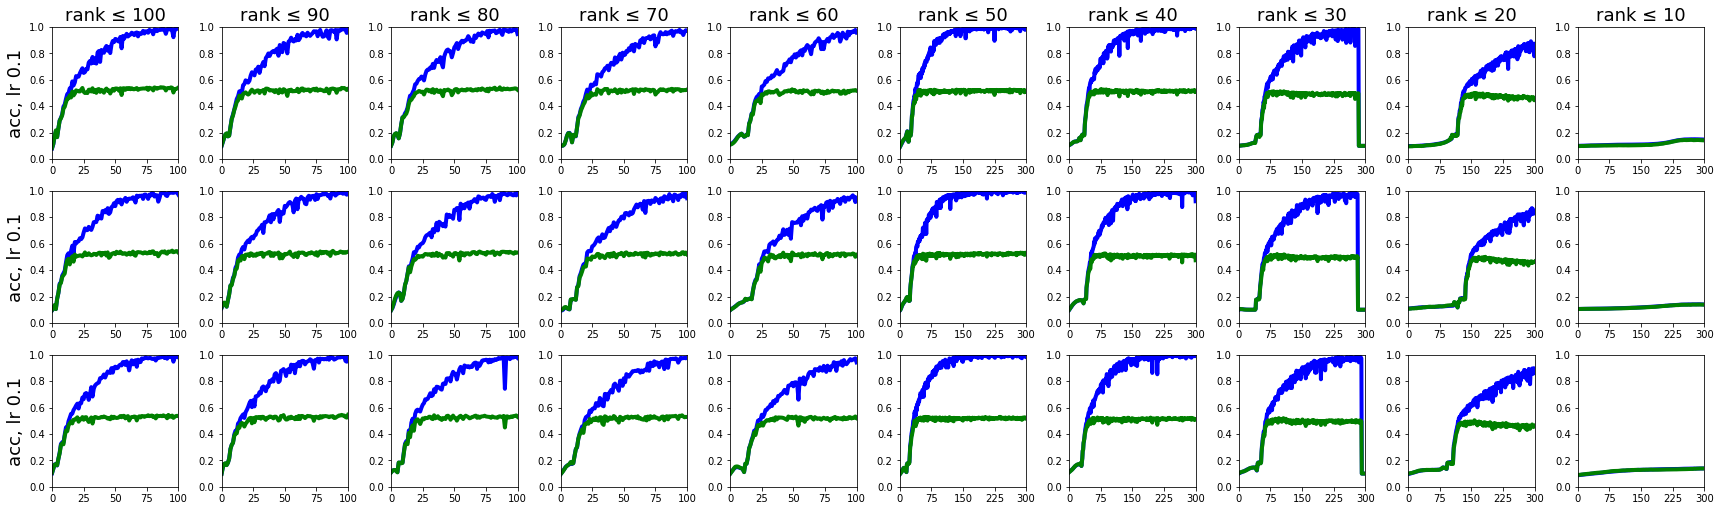

In [119]:
n_layers = 6
m_per_layer = 1000
n_epochs = 300
batch_size = 128
lr = 0.1
init_randoms = range(0, 3)
#max_ranks = range(1000, 99, -100)
#max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
max_ranks = list(range(100, 9, -10))
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        n_epochs = 300 if max_rank <= 50 else 100
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_6l/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        #ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, n_epochs)
        ax.set_xticks(np.linspace(0, n_epochs, 5))
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        ax.plot(data["train_acc"], color="b", linewidth=4)
        ax.plot(data["test_acc"], color="g", linewidth=4)
        ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"acc, lr {lr}", fontsize=18)
        if i==len(learning_rates)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

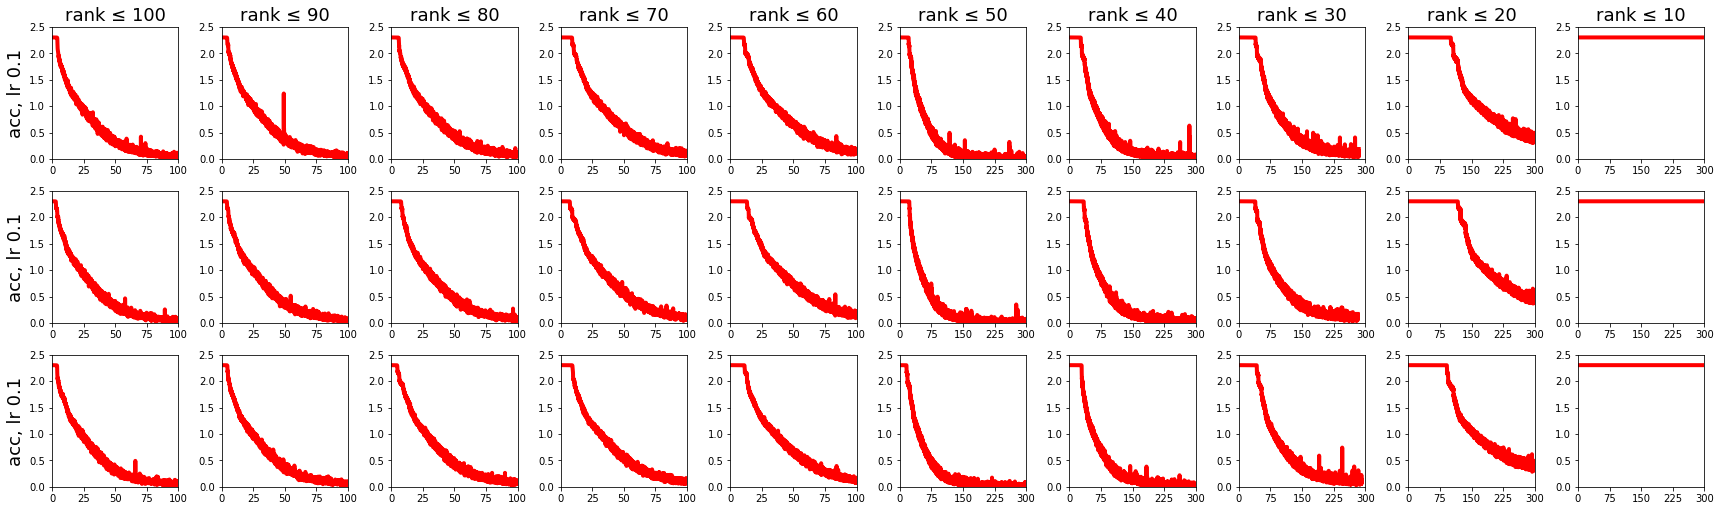

In [120]:
n_layers = 6
m_per_layer = 1000
n_epochs = 300
batch_size = 128
lr = 0.1
init_randoms = range(0, 3)
#max_ranks = range(1000, 99, -100)
#max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
max_ranks = list(range(100, 9, -10))
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        n_epochs = 300 if max_rank <= 50 else 100
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_6l/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, n_epochs)
        ax.set_xticks(np.linspace(0, n_epochs, 5))
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"acc, lr {lr}", fontsize=18)
        if i==len(learning_rates)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

## 6 layers 500 per layer

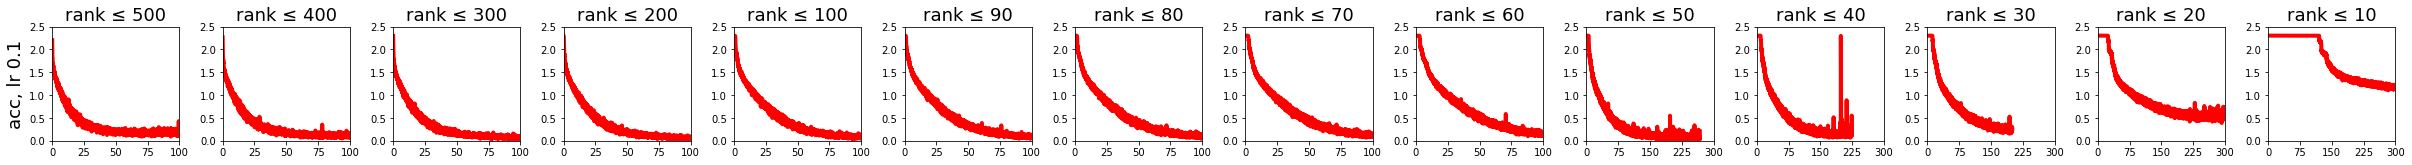

In [122]:
n_layers = 6
m_per_layer = 500
n_epochs = 300
batch_size = 128
lr = 0.1
init_randoms = range(0, 1)
#max_ranks = range(1000, 99, -100)
#max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
max_ranks = list(range(500, 199, -100))+list(range(100, 9, -10))
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        n_epochs = 300 if max_rank <= 50 else 100
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_6l_500/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, n_epochs)
        ax.set_xticks(np.linspace(0, n_epochs, 5))
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"acc, lr {lr}", fontsize=18)
        if i==len(learning_rates)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

500_0: 101.75579129854837
400_0: 93.3245138168335
300_0: 82.50531378189723
200_0: 71.73909811973571
100_0: 64.771997042497
90_0: 62.461126621564226
80_0: 59.625049062569936
70_0: 58.94468353589376
60_0: 60.51130566596985
50_0: 155.16352395613987
40_0: 150.35535471836727
30_0: 148.9248537103335
20_0: 149.0346907933553
10_0: 143.51742316087086


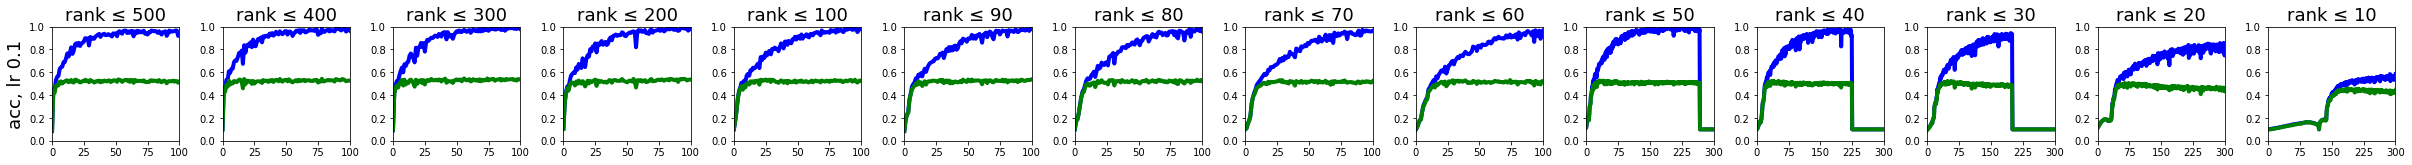

In [124]:
n_layers = 6
m_per_layer = 500
n_epochs = 300
batch_size = 128
lr = 0.1
init_randoms = range(0, 1)
#max_ranks = range(1000, 99, -100)
#max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
max_ranks = list(range(500, 199, -100))+list(range(100, 9, -10))
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        n_epochs = 300 if max_rank <= 50 else 100
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_6l_500/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        #ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, n_epochs)
        ax.set_xticks(np.linspace(0, n_epochs, 5))
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        ax.plot(data["train_acc"], color="b", linewidth=4)
        ax.plot(data["test_acc"], color="g", linewidth=4)
        ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"acc, lr {lr}", fontsize=18)
        if i==len(learning_rates)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

## 200

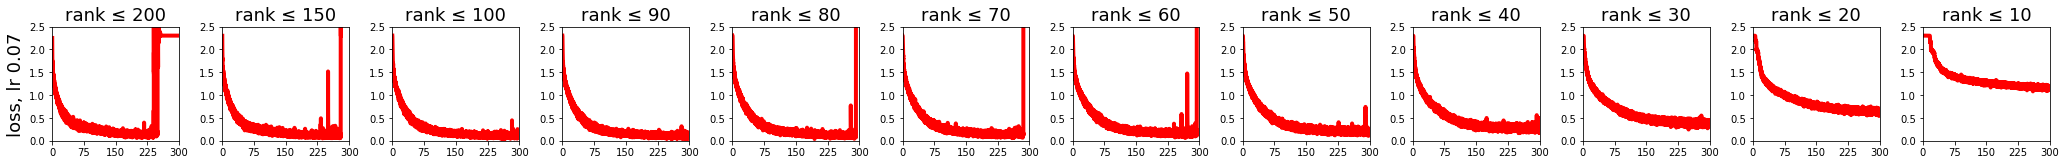

In [128]:
n_layers = 6
m_per_layer = 200
n_epochs = 300
batch_size = 128
lr = 0.07
init_randoms = range(0, 1)
#max_ranks = range(1000, 99, -100)
#max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
max_ranks = [200,150]+list(range(100, 9, -10))
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        n_epochs = 300 #if max_rank <= 50 else 100
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_6l_200/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, n_epochs)
        ax.set_xticks(np.linspace(0, n_epochs, 5))
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"loss, lr {lr}", fontsize=18)
        if i==len(learning_rates)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

200_0: 201.66568414767582
150_0: 188.81335365772247
100_0: 175.07981381813684
90_0: 174.4683232943217
80_0: 169.6714165767034
70_0: 173.63362771670023
60_0: 164.52060286601383
50_0: 162.29075166781743
40_0: 159.22861642042795
30_0: 176.379607462883
20_0: 120.78402562936147
10_0: 111.7846254269282


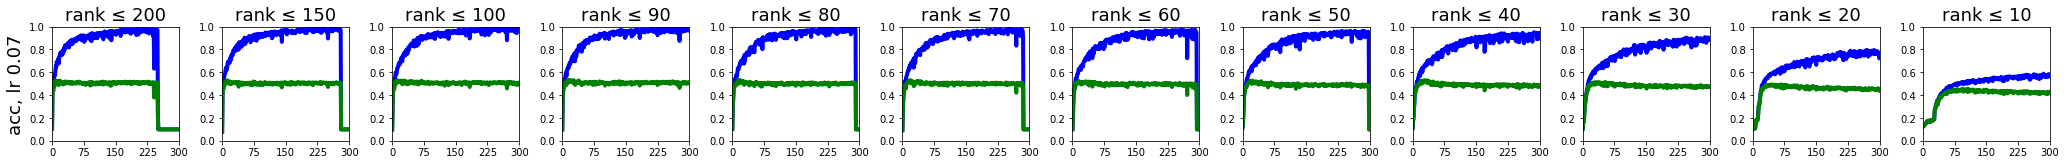

In [131]:
n_layers = 6
m_per_layer = 200
n_epochs = 300
batch_size = 128
lr = 0.07
init_randoms = range(0, 1)
#max_ranks = range(1000, 99, -100)
#max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
max_ranks = [200,150]+list(range(100, 9, -10))
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        n_epochs = 300 #if max_rank <= 50 else 100
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_6l_200/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        #ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, n_epochs)
        ax.set_xticks(np.linspace(0, n_epochs, 5))
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        ax.plot(data["train_acc"], color="b", linewidth=4)
        ax.plot(data["test_acc"], color="g", linewidth=4)
        ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"acc, lr {lr}", fontsize=18)
        if i==len(learning_rates)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

### 6l 200 t

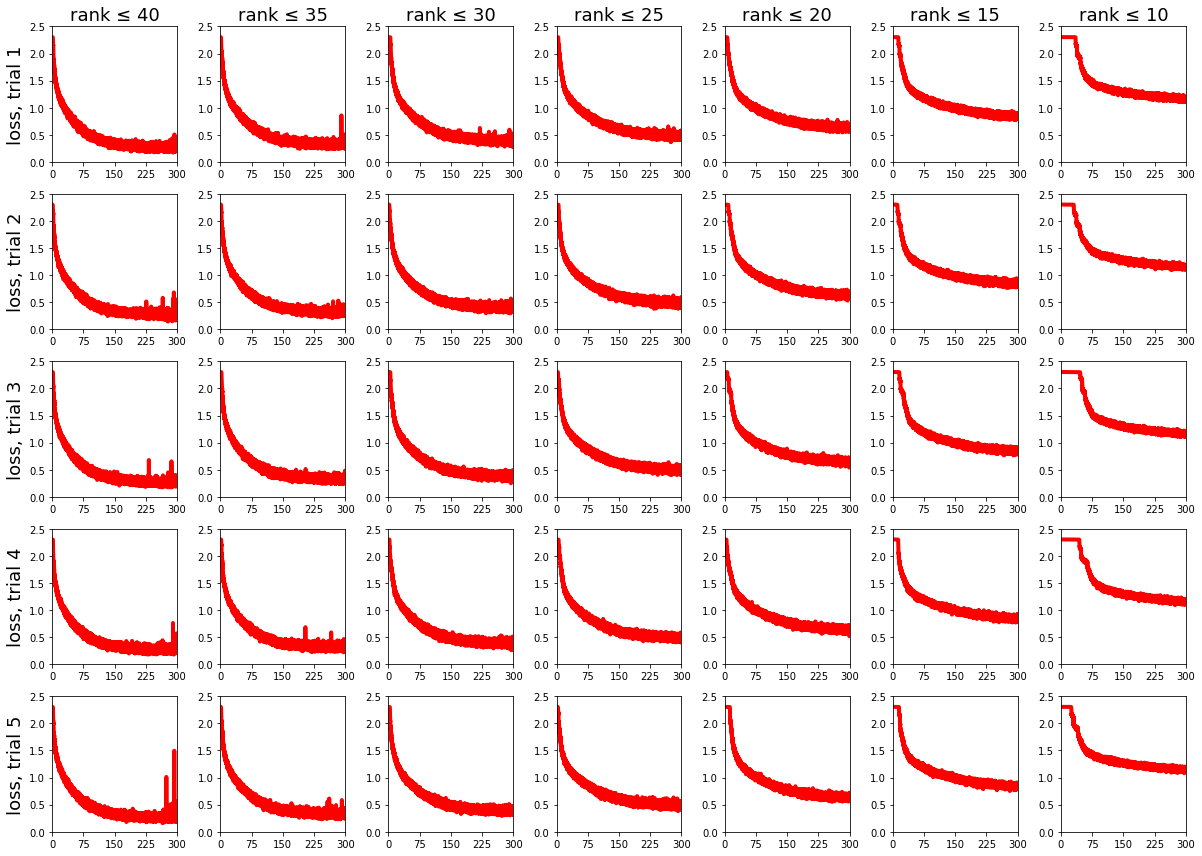

In [141]:
n_layers = 6
m_per_layer = 200
n_epochs = 300
batch_size = 128
lr = 0.07
init_randoms = range(0, 5)
#max_ranks = range(1000, 99, -100)
#max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
max_ranks = list(range(40, 9, -5))
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        n_epochs = 300 #if max_rank <= 50 else 100
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_6l_200_t/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, n_epochs)
        ax.set_xticks(np.linspace(0, n_epochs, 5))
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"loss, trial {i+1}", fontsize=18)
        if i==len(learning_rates)-1:
            ax.set_xlabel("epoch", fontsize=16)
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

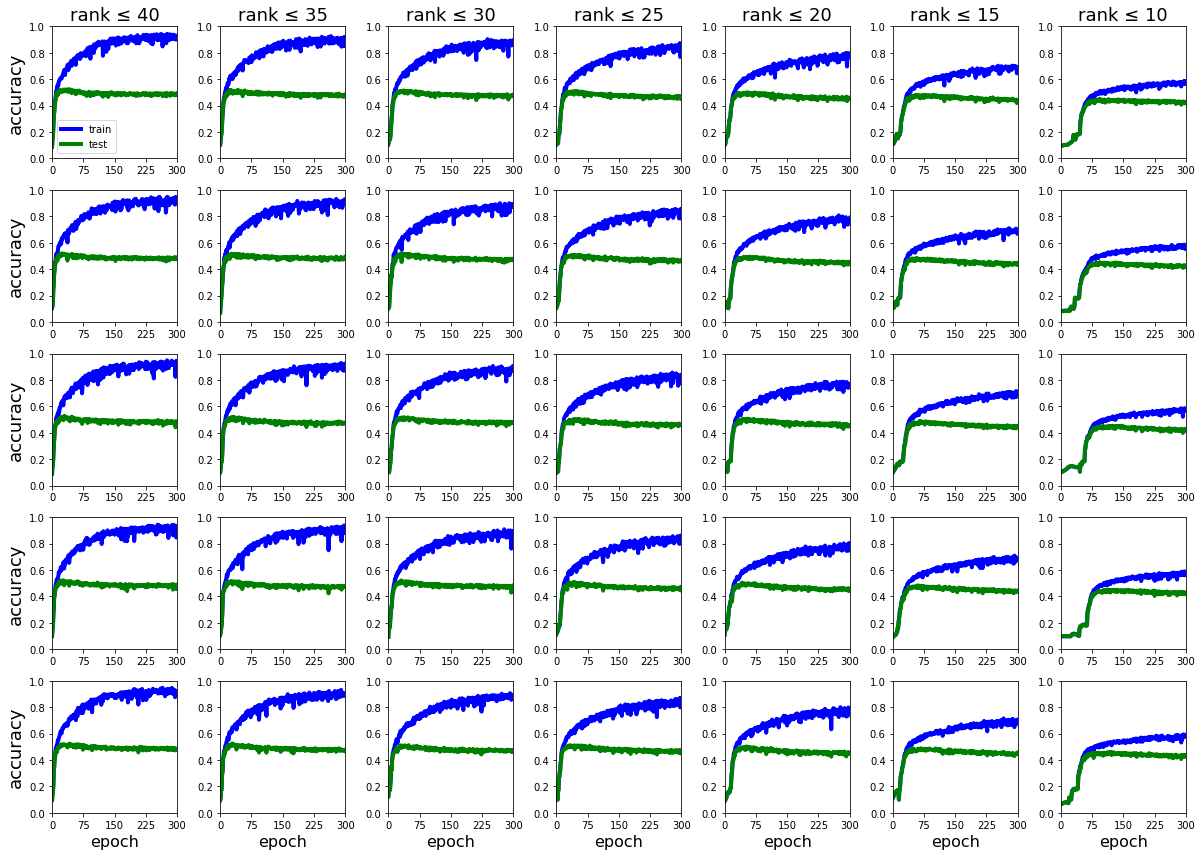

In [165]:
n_layers = 6
m_per_layer = 200
n_epochs = 300
batch_size = 128
lr = 0.07
init_randoms = range(0, 5)
#max_ranks = range(1000, 99, -100)
#max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
max_ranks = list(range(40, 9, -5))
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        n_epochs = 300 #if max_rank <= 50 else 100
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_6l_200_t/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        #ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, n_epochs)
        ax.set_xticks(np.linspace(0, n_epochs, 5))
        ax.plot(data["train_acc"], color="b", linewidth=4, label="train")
        ax.plot(data["test_acc"], color="g", linewidth=4, label="test")
        ax.set_ylim(0, 1)
        #print(data["losses"])
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"accuracy", fontsize=18)
        if i==len(init_randoms)-1:
            ax.set_xlabel("epoch", fontsize=16)
        if i==0 and j==0:
            ax.legend()
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

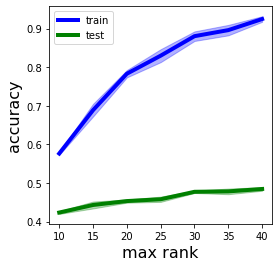

In [167]:
n_layers = 6
m_per_layer = 200
n_epochs = 300
batch_size = 128
lr = 0.07
init_randoms = range(0, 5)
#max_ranks = range(1000, 99, -100)
#max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
max_ranks = list(range(40, 9, -5))
train_acc, test_acc = np.zeros((len(init_randoms), len(max_ranks))), np.zeros((len(init_randoms), len(max_ranks)))
for j, max_rank in enumerate(max_ranks):
    c_tr_a = []
    c_te_a = []
    for i, init_random in enumerate(init_randoms):
        n_epochs = 300 #if max_rank <= 50 else 100
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_6l_200_t/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        train_acc[i, j] = data["train_acc"][-1]
        test_acc[i, j] = data["test_acc"][-1]
    
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)

plt.figure(figsize=(4, 4))
plt.fill_between(max_ranks, np.mean(train_acc, axis=0)-np.std(train_acc, axis=0), np.mean(train_acc, axis=0)+np.std(train_acc, axis=0), color="b", alpha=0.3)
plt.fill_between(max_ranks, np.mean(test_acc, axis=0)-np.std(test_acc, axis=0), np.mean(test_acc, axis=0)+np.std(test_acc, axis=0), color="g", alpha=0.3)
plt.plot(max_ranks, np.mean(train_acc, axis=0), color="b", linewidth=4, label="train")
plt.plot(max_ranks, np.mean(test_acc, axis=0), color="g", linewidth=4, label="test")
plt.xlabel("max rank", fontsize=16)
plt.ylabel("accuracy", fontsize=16)
plt.legend()
#plt.ylim(0, 1)

### 6 200 second

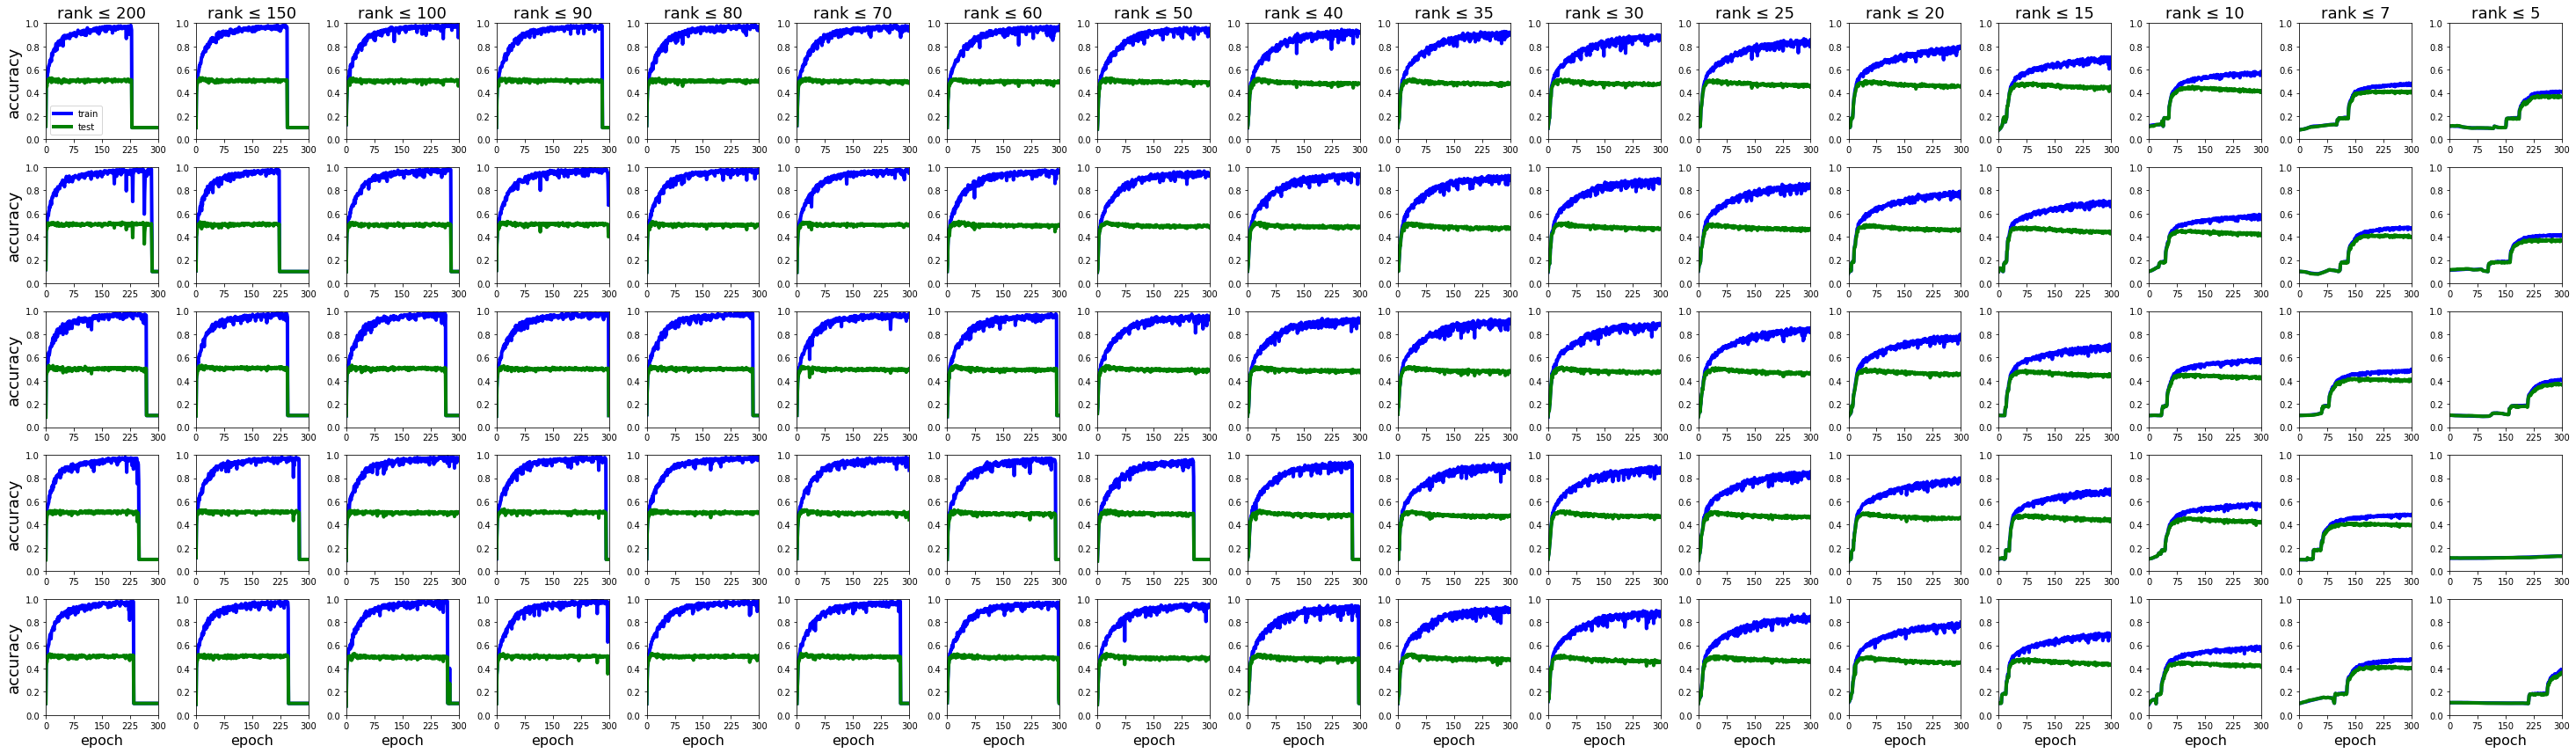

In [170]:
n_layers = 6
m_per_layer = 200
n_epochs = 300
batch_size = 128
lr = 0.07
init_randoms = range(0, 5)
#max_ranks = range(1000, 99, -100)
#max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
max_ranks = [200, 150] + list(range(100, 49, -10)) + list(range(40, 9, -5)) + [7, 5] 
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        n_epochs = 300 #if max_rank <= 50 else 100
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_6l_200_with_networks/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        #ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, n_epochs)
        ax.set_xticks(np.linspace(0, n_epochs, 5))
        ax.plot(data["train_acc"], color="b", linewidth=4, label="train")
        ax.plot(data["test_acc"], color="g", linewidth=4, label="test")
        ax.set_ylim(0, 1)
        #print(data["losses"])
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"accuracy", fontsize=18)
        if i==len(init_randoms)-1:
            ax.set_xlabel("epoch", fontsize=16)
        if i==0 and j==0:
            ax.legend()
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

No handles with labels found to put in legend.


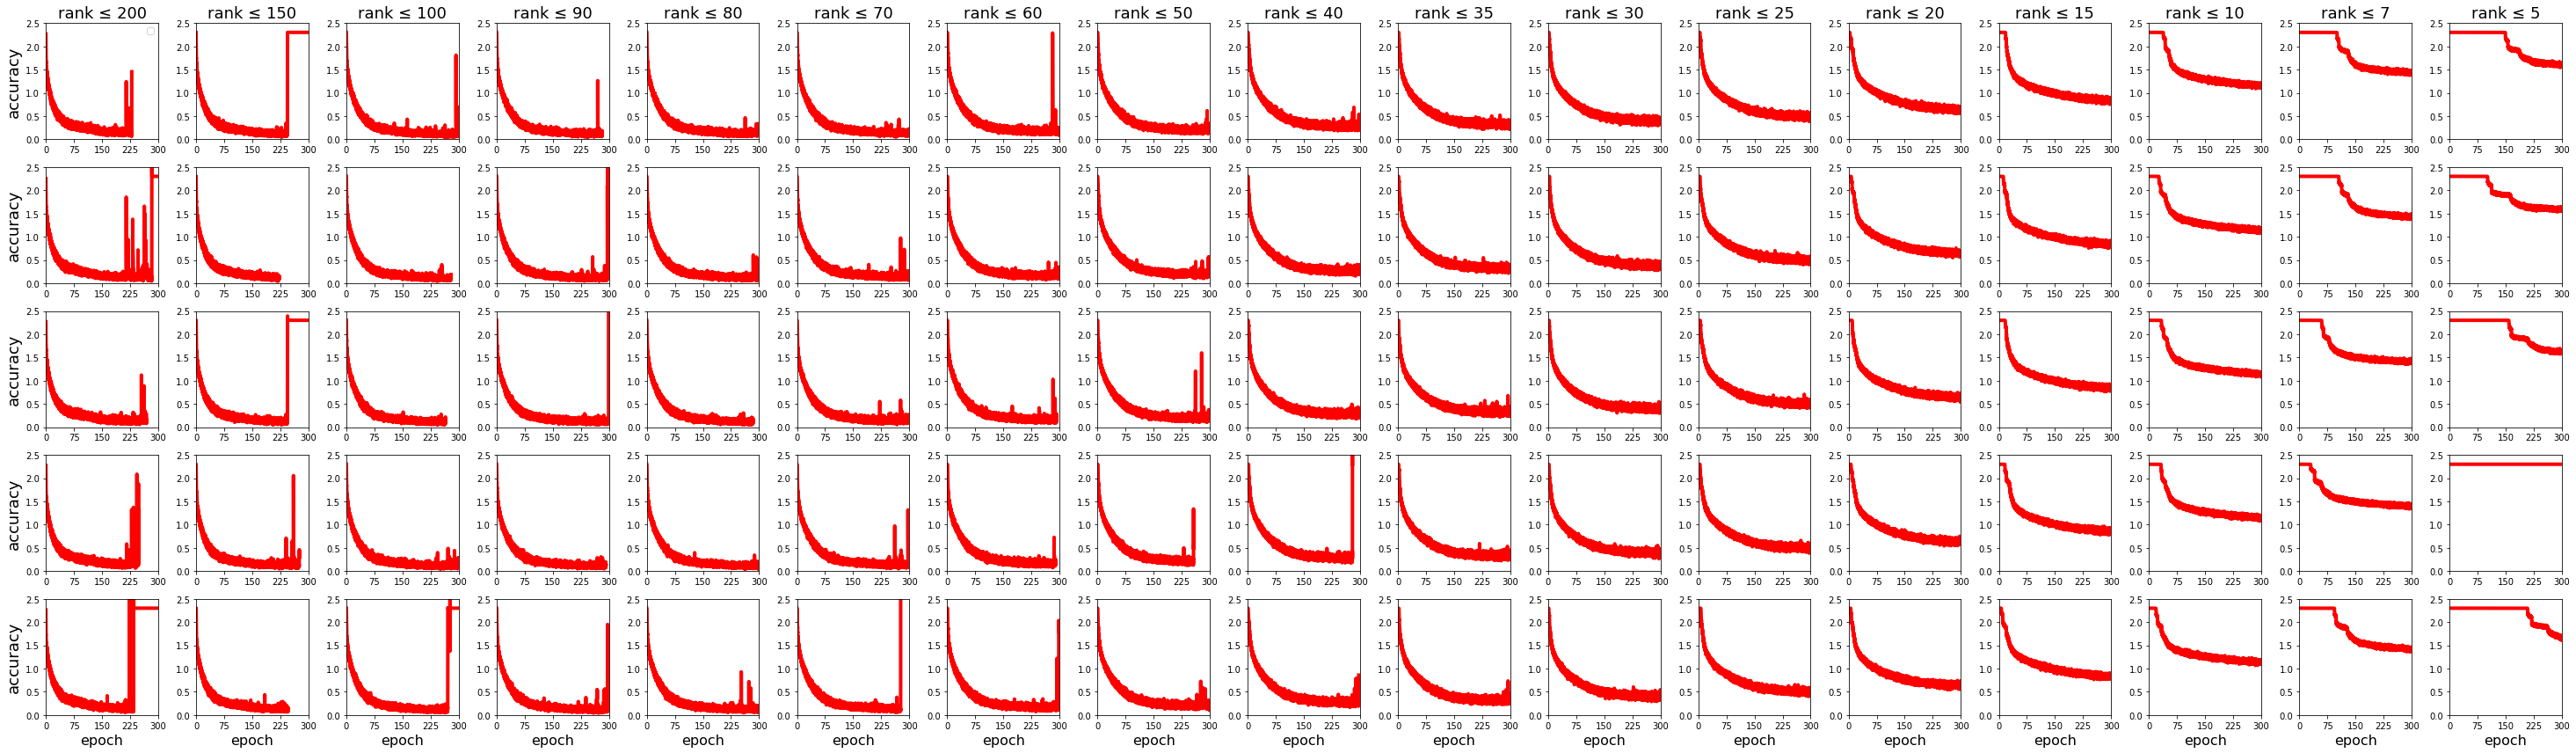

In [171]:
n_layers = 6
m_per_layer = 200
n_epochs = 300
batch_size = 128
lr = 0.07
init_randoms = range(0, 5)
#max_ranks = range(1000, 99, -100)
#max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
max_ranks = [200, 150] + list(range(100, 49, -10)) + list(range(40, 9, -5)) + [7, 5] 
fig = plt.figure(figsize=(24/10*len(max_ranks), 12/5*len(init_randoms)))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        n_epochs = 300 #if max_rank <= 50 else 100
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}"
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        with open(f"results_6l_200_with_networks/{filename}.json", 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        ax = fig.add_subplot(len(init_randoms), len(max_ranks), i * len(max_ranks) + j+1)
        ax.plot(np.linspace(0, n_epochs, len(data["losses"])), np.array(data["losses"])/20, color="r", linewidth=4)
        ax.set_ylim(0, 2.5)
        ax.set_xlim(0, n_epochs)
        ax.set_xticks(np.linspace(0, n_epochs, 5))
        #ax.plot(data["train_acc"], color="b", linewidth=4, label="train")
        #ax.plot(data["test_acc"], color="g", linewidth=4, label="test")
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        #ax.plot(data["train_acc"], color="b", linewidth=4)
        #ax.plot(data["test_acc"], color="g", linewidth=4)
        #ax.set_ylim(0, 1)
        #print(data["losses"])
        if i==0:
            ax.set_title(f"rank ≤ {max_rank}", fontsize=18)
        if j==0:
            ax.set_ylabel(f"accuracy", fontsize=18)
        if i==len(init_randoms)-1:
            ax.set_xlabel("epoch", fontsize=16)
        if i==0 and j==0:
            ax.legend()
        
        #print(f"{max_rank}_{init_random}: {(data['end_time']-data['start_time'])/60}")

#st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
#fig.supylabel('training loss\n', fontsize=20)
#fig.supxlabel(f'epoch', fontsize=20)
#fig.subplots_adjust(top=0.95, left=0.05, bottom=0.04)
#fig.subplots_adjust(left=0.1, bottom=0.1)
plt.tight_layout()

In [200]:
n_layers = 6
m_per_layer = 200
n_epochs = 300
batch_size = 128
lr = 0.07
init_randoms = 0
max_rank = 100
n_epochs = 300

filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
net = Net_Rank(N_layers=n_layers, M_per_layer=m_per_layer, max_rank=max_rank)
state_dict = torch.load(f"results_6l_200_with_networks/{filename}_best.pth")["model_state_dict"]
net.load_state_dict(state_dict)

for layer_i in range(n_layers):
    #print((net.layers_b[layer_i].weight @ net.layers_a[layer_i].weight).shape)
    #plt.imshow((net.layers_b[layer_i].weight @ net.layers_a[layer_i].weight).detach().numpy())
    #plt.show()
    
    W = net.layers_b[layer_i].weight @ net.layers_a[layer_i].weight
    u, s, vT = np.linalg.svd(W.detach().numpy(), full_matrices=False)  # np.linalg.svd returns v transpose!
    #            Wahh = u @ vT  # make the eigenvalues large so they decay slowly
    rank = (sum(s>10**(-4)))
                

In [188]:
net.layers_a[0].weight.shape

torch.Size([100, 3072])

In [204]:
n_layers = 6
m_per_layer = 200
n_epochs = 300
batch_size = 128
lr = 0.07
init_randoms = range(0, 5)
#max_ranks = range(1000, 99, -100)
#max_ranks = list(range(1000, 99, -100))+list(range(90, 49, -10))
max_ranks = [200, 150] + list(range(100, 49, -10)) + list(range(40, 9, -5)) + [7, 5] 
ranks = np.zeros((len(init_randoms), len(max_ranks), n_layers))
rhos = np.zeros((len(init_randoms), len(max_ranks), n_layers))
for j, max_rank in enumerate(max_ranks):
    for i, init_random in enumerate(init_randoms):
        filename = f"r{max_rank}_i{init_random}_n{n_layers}_m{m_per_layer}_e{n_epochs}_b{batch_size}_lr{lr}"
        net = Net_Rank(N_layers=n_layers, M_per_layer=m_per_layer, max_rank=max_rank)
        state_dict = torch.load(f"results_6l_200_with_networks/{filename}_best.pth")["model_state_dict"]
        net.load_state_dict(state_dict)

        for layer_i in range(n_layers):
            #print((net.layers_b[layer_i].weight @ net.layers_a[layer_i].weight).shape)
            #plt.imshow((net.layers_b[layer_i].weight @ net.layers_a[layer_i].weight).detach().numpy())
            #plt.show()

            W = net.layers_b[layer_i].weight @ net.layers_a[layer_i].weight
            u, s, vT = np.linalg.svd(W.detach().numpy(), full_matrices=False)  # np.linalg.svd returns v transpose!
            #            Wahh = u @ vT  # make the eigenvalues large so they decay slowly
            ranks[i, j, layer_i] = (sum(s>10**(-2)))
            rhos[i, j, layer_i] = torch.sum(W**2).item()**0.5

<ErrorbarContainer object of 3 artists>

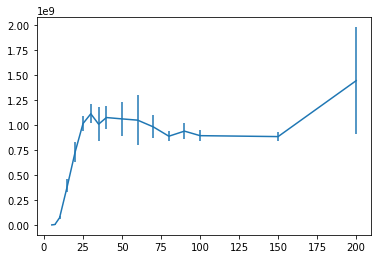

In [221]:
plt.errorbar(max_ranks, np.mean(np.prod(rhos, axis=2), axis=0), yerr=np.std(np.prod(rhos, axis=2), axis=0))

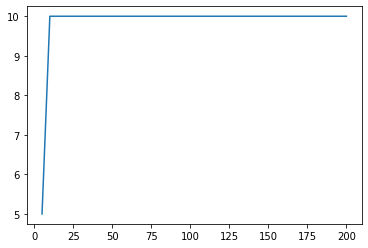

In [220]:
plt.plot(max_ranks, np.mean(ranks, axis=0)[:, 5])